In [ ]:
import pandas as pd
import os

# Path to the directory containing your CSV files
folder_path = "../yfinance_data/the file"  # Make sure this path is correct

# Dictionary to hold individual DataFrames
data_dict = {}

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        stock_name = filename.replace(".csv", "")
        file_path = os.path.join(folder_path, filename)
        
        # Load CSV into DataFrame with datetime index
        df = pd.read_csv(file_path, parse_dates=True, index_col=0)
        
        # Ensure index is datetime and add normalized date
        df.index = pd.to_datetime(df.index)
        df['Date'] = df.index.normalize()
        
        # Save to dictionary
        data_dict[stock_name] = df

In [102]:
# For news data
news_df=pd.read_csv("C:/Users/Student/Documents/kaim documents/week 1/raw_analyst_ratings.csv/raw_analyst_ratings.csv")
# Step 1: Convert to datetime (safely)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
print(news_df['date'].dtype)
print(news_df['date'].head())


datetime64[ns, UTC-04:00]
0   2020-06-05 10:30:54-04:00
1   2020-06-03 10:45:20-04:00
2   2020-05-26 04:30:07-04:00
3   2020-05-22 12:45:06-04:00
4   2020-05-22 11:38:59-04:00
Name: date, dtype: datetime64[ns, UTC-04:00]


In [110]:
news_df = pd.read_csv("C:/Users/Student/Documents/kaim documents/week 1/raw_analyst_ratings.csv/raw_analyst_ratings.csv")

news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

print(news_df['date'].dtype)
print(news_df['date'].head())

news_df = news_df.dropna(subset=['date'])  # Drop NaT values

# Remove timezone to avoid errors with .dt.normalize()
news_df['date'] = news_df['date'].dt.tz_localize(None)

# Normalize date to midnight
news_df['date'] = news_df['date'].dt.normalize()
news_df = news_df.dropna(subset=['date'])

print(news_df['date'].tail())
print(news_df['date'].dtype)


datetime64[ns, UTC-04:00]
0   2020-06-05 10:30:54-04:00
1   2020-06-03 10:45:20-04:00
2   2020-05-26 04:30:07-04:00
3   2020-05-22 12:45:06-04:00
4   2020-05-22 11:38:59-04:00
Name: date, dtype: datetime64[ns, UTC-04:00]
1407266   2018-01-05
1407267   2017-12-06
1407268   2017-12-06
1407269   2017-11-15
1407270   2017-11-14
Name: date, dtype: datetime64[ns]
datetime64[ns]


In [105]:
import pandas as pd
import numpy as np
import os
from datetime import time
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from textblob import TextBlob

In [106]:
# 1. Load your datasets
def load_data():
    """Load news and stock data from your specific paths"""
    # Load news data
    news_df = pd.read_csv("C:/Users/Student/Documents/kaim documents/week 1/raw_analyst_ratings.csv/raw_analyst_ratings.csv")
    
    # Load stock data from multiple files
    folder_path = "../yfinance_data/the file"
    data_dict = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            stock_name = filename.replace(".csv", "")
            file_path = os.path.join(folder_path, filename)
            data_dict[stock_name] = pd.read_csv(file_path, parse_dates=True, index_col=0)
    
    return news_df, data_dict
news_df, data_dict = load_data()


In [109]:
# 2. Preprocess and align data
def preprocess_data(news_df, data_dict):
    """Clean and prepare data for analysis"""
    # Convert news timestamp to datetime
    news_df = news_df.copy()
    news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
    news_df =news_df.dropna(subset=['date'])  # Remove rows where conversion failed
    news_df['date'] =news_df['date'].dt.normalize().dt.tz_localize(None)
    

    
    # Create a combined stock DataFrame with ticker information
    stock_dfs = []
    for ticker, df in data_dict.items():
        temp_df = df.copy()
        temp_df['Ticker'] = ticker
        stock_dfs.append(temp_df)
    
    combined_stocks=pd.concat(stock_dfs)
    combined_stocks.index = pd.to_datetime(combined_stocks.index)

    return news_df, combined_stocks
# Call the function and store the result

# Now preprocess and align the data
clean_news_df, combined_stocks_df = preprocess_data(news_df, data_dict)

# Check the results
print(combined_stocks_df.tail())
print(combined_stocks_df.columns)


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-24  225.419998  225.990005  214.710007  215.990005  215.990005   
2024-07-25  216.800003  226.000000  216.229996  220.250000  220.250000   
2024-07-26  221.190002  222.279999  215.330002  219.800003  219.800003   
2024-07-29  224.899994  234.270004  224.699997  232.100006  232.100006   
2024-07-30  232.250000  232.410004  220.000000  222.619995  222.619995   

               Volume  Dividends  Stock Splits                Ticker  
Date                                                                  
2024-07-24  167942900        0.0           0.0  TSLA_historical_data  
2024-07-25  100636500        0.0           0.0  TSLA_historical_data  
2024-07-26   94604100        0.0           0.0  TSLA_historical_data  
2024-07-29  129201800        0.0           0.0  TSLA_historical_data  
2024-07-30  100560300        0.0           0.0  TSLA_hi

In [111]:
# Parse datetime with timezone info
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Convert to timezone naive (optional)
news_df['date'] = news_df['date'].dt.tz_localize(None)

# Normalize to remove time (keep date only)
news_df['date'] = news_df['date'].dt.normalize()

print(news_df['date'].dtype)
print(news_df['date'].head())

datetime64[ns]
0   2020-06-05
1   2020-06-03
2   2020-05-26
3   2020-05-22
4   2020-05-22
Name: date, dtype: datetime64[ns]


## 🔄 Align News with Stock Trading Days

This function aligns each news article with the correct stock trading day based on its timestamp.

### 🕒 Market Hours Assumption
- **Market Open:** 9:30 AM  
- **Market Close:** 4:00 PM  

### 📌 Logic:
- News during trading hours → same day (if valid trading day)
- After market close → next valid trading day
- Before market open → same day (if valid)

### ✅ Returns:
- `aligned_news`: News DataFrame with a new `trading_day` column.
- Removes rows that couldn't be matched to a valid trading day.

### 📂 Requirements:
- `news_df['date']` must be `datetime64[ns]`
- `combined_stocks_df.index` must be `datetime64[ns]`


In [112]:
from datetime import time
import pandas as pd

def align_news_with_stocks(news_df, combined_stocks_df):
    """Assign each news article to a valid trading day in the stock data."""
    
    # Define market open and close times
    MARKET_OPEN = time(9, 30)
    MARKET_CLOSE = time(16, 0)

    # Get unique trading days (dates only) from stock_dfs index
    trading_days = combined_stocks_df.index.normalize().unique()

    def assign_trading_day(date):
        if pd.isnull(date):
            return None

        ts_time = date.time()
        ts_date = date.date()
        day = pd.Timestamp(ts_date)

        # During market hours: assign to that day if valid
        if MARKET_OPEN <= ts_time <= MARKET_CLOSE:
            return day if day in trading_days else None

        # After market close: assign to next trading day
        elif ts_time > MARKET_CLOSE:
            next_day = day + pd.Timedelta(days=1)
            while next_day not in trading_days:
                next_day += pd.Timedelta(days=1)
            return next_day

        # Before market open: assign to same day if valid
        else:
            return day if day in trading_days else None

    # Apply the function to assign trading day for each news date
    news_df['trading_day'] = news_df['date'].apply(assign_trading_day)

    # Drop rows where trading_day assignment failed
    aligned_news = news_df.dropna(subset=['trading_day'])

    return aligned_news

# Example usage:
# Make sure news_df and stock_df are defined and have proper datetime indices
# For example:
# news_df['date'] should be datetime64[ns]
# stock_df.index should be datetime64[ns]

aligned_news = align_news_with_stocks(news_df, combined_stocks_df)

# Print info to verify
print(aligned_news.head())
# aligned_news.info()


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

        date stock trading_day  
0 2020-06-05     A  2020-06-05  
1 2020-06-03     A  2020-06-03  
2 2020-05-26     A  2020-05-26  
3 2020-0

In [113]:
print("News shape:", news_df.shape)
print("Stock shape:", combined_stocks_df.shape)
print("Aligned News shape:", aligned_news.shape)

print("Missing in aligned_news:")
print(aligned_news.isnull().sum())


News shape: (55987, 7)
Stock shape: (45428, 9)
Aligned News shape: (55230, 7)
Missing in aligned_news:
Unnamed: 0     0
headline       0
url            0
publisher      0
date           0
stock          0
trading_day    0
dtype: int64


In [114]:
print(news_df.columns)
print(combined_stocks_df.columns)
print(aligned_news.columns)


Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'trading_day'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'Ticker'],
      dtype='object')
Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'trading_day'],
      dtype='object')


In [134]:
combined_stocks_df = combined_stocks_df.drop(columns=['level_0', 'trading_day'], errors='ignore')
print(combined_stocks_df.columns)
print(combined_stocks_df.head())


Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Ticker'],
      dtype='object')
   index       Date      Open      High       Low     Close  Adj Close  \
0      0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943   
1      1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781   
2      2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898   
3      3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   
4      4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   

      Volume  Dividends  Stock Splits                Ticker  
0  469033600        0.0           0.0  AAPL_historical_data  
1  175884800        0.0           0.0  AAPL_historical_data  
2  105728000        0.0           0.0  AAPL_historical_data  
3   86441600        0.0           0.0  AAPL_historical_data  
4   73449600        0.0           0.0  AAPL_historical_data  


In [135]:
# Assuming 'trading_day' column in aligned news and stock_df['date'] exists
aligned_news = news_df.dropna(subset=['trading_day']).copy()
aligned_news['trading_day'] = pd.to_datetime(aligned_news['trading_day'])
combined_stocks_df['Date'] = pd.to_datetime(combined_stocks_df['Date'])  # or from index if needed

# Merge on 'trading_day'
merged_df = pd.merge(aligned_news, combined_stocks_df, left_on='trading_day', right_on='Date', how='inner')
print(merged_df.columns)
print(merged_df.head())

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'trading_day', 'neg', 'neu', 'pos', 'compound', 'index', 'Date', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'Ticker'],
      dtype='object')
   Unnamed: 0                                 headline  \
0           0  Stocks That Hit 52-Week Highs On Friday   
1           0  Stocks That Hit 52-Week Highs On Friday   
2           0  Stocks That Hit 52-Week Highs On Friday   
3           0  Stocks That Hit 52-Week Highs On Friday   
4           0  Stocks That Hit 52-Week Highs On Friday   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
3  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
4  

In [136]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon once
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if pd.isnull(text):
        return None
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

# Assuming your news dataframe has a 'headline' column (change it to your text column)
news_df['sentiment'] = news_df['headline'].apply(analyze_sentiment)

# This will create a new column with a dict of sentiment scores for each row:
# Example of one row: {'neg': 0.0, 'neu': 0.3, 'pos': 0.7, 'compound': 0.8}

# If you want to split these into separate columns:
news_df = pd.concat([news_df.drop(['sentiment'], axis=1), 
                     news_df['sentiment'].apply(pd.Series)], axis=1)

# Now you have 'neg', 'neu', 'pos', and 'compound' as separate columns

print(news_df.head())



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

        date stock trading_day  neg    neu    pos  compound  neg    neu  \
0 2020-06-05     A  2020-06-05  0.0  1.000  0.000     0.000  0.0 

In [143]:
daily_sentiment = news_df.groupby('trading_day')[['neg', 'neu', 'pos', 'compound']].mean().reset_index()
print(daily_sentiment.head(15))
print(aligned_news.columns)

   trading_day       neg       neg       neu       neu       pos       pos  \
0   2011-04-27  0.000000  0.000000  1.000000  1.000000  0.000000  0.000000   
1   2011-04-28  0.069000  0.069000  0.796000  0.796000  0.135000  0.135000   
2   2011-04-29  0.000000  0.000000  0.820000  0.820000  0.180000  0.180000   
3   2011-05-02  0.000000  0.000000  0.849889  0.849889  0.150111  0.150111   
4   2011-05-03  0.000000  0.000000  1.000000  1.000000  0.000000  0.000000   
5   2011-05-05  0.066667  0.066667  0.933333  0.933333  0.000000  0.000000   
6   2011-05-06  0.000000  0.000000  0.944333  0.944333  0.055667  0.055667   
7   2011-05-09  0.090667  0.090667  0.909333  0.909333  0.000000  0.000000   
8   2011-05-11  0.000000  0.000000  0.814333  0.814333  0.185667  0.185667   
9   2011-05-12  0.000000  0.000000  0.833000  0.833000  0.167000  0.167000   
10  2011-05-13  0.000000  0.000000  0.811500  0.811500  0.188500  0.188500   
11  2011-05-16  0.000000  0.000000  1.000000  1.000000  0.000000

In [144]:
# Make sure 'trading_day' column is datetime type and normalized (no time part)
aligned_news = aligned_news.drop(columns=['neg', 'neu', 'pos', 'compound'], errors='ignore')
aligned_news['trading_day'] = pd.to_datetime(aligned_news['trading_day']).dt.normalize()

# Also normalize the daily_sentiment trading_day column to match exactly
daily_sentiment['trading_day'] = pd.to_datetime(daily_sentiment['trading_day']).dt.normalize()

# Merge stock data with daily sentiment scores
merged_df = pd.merge(aligned_news, daily_sentiment, on='trading_day', how='left')

print(merged_df.tail())


       Unnamed: 0                                           headline  \
55225     1413787  Chinese Nano-Cap Momentum Stocks Sharply Highe...   
55226     1413788  28 Stocks Moving In Wednesday's Pre-Market Ses...   
55227     1413789  China Zenix Auto International Reports Q3 EPAD...   
55228     1413790                   46 Biggest Movers From Yesterday   
55229     1413791      42 Stocks Moving In Tuesday's Mid-Day Session   

                                                     url      publisher  \
55225  https://www.benzinga.com/movers/18/01/10994518...  Paul Quintaro   
55226  https://www.benzinga.com/news/17/12/10878295/2...     Lisa Levin   
55227  https://www.benzinga.com/news/earnings/17/12/1...  Paul Quintaro   
55228  https://www.benzinga.com/news/17/11/10788120/4...     Lisa Levin   
55229  https://www.benzinga.com/news/17/11/10782008/4...     Lisa Levin   

            date stock trading_day       neg       neg       neu       neu  \
55225 2018-01-05    ZX  2018-01-05  0.

In [139]:
print(aligned_news.columns)
print(combined_stocks_df.columns)

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'trading_day', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')
Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Ticker'],
      dtype='object')


In [140]:
print(combined_stocks_df.head())

   index       Date      Open      High       Low     Close  Adj Close  \
0      0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943   
1      1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781   
2      2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898   
3      3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   
4      4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   

      Volume  Dividends  Stock Splits                Ticker  
0  469033600        0.0           0.0  AAPL_historical_data  
1  175884800        0.0           0.0  AAPL_historical_data  
2  105728000        0.0           0.0  AAPL_historical_data  
3   86441600        0.0           0.0  AAPL_historical_data  
4   73449600        0.0           0.0  AAPL_historical_data  


In [147]:
print(merged_df.columns)

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'trading_day', 'neg', 'neg', 'neu', 'neu', 'pos', 'pos', 'compound',
       'compound'],
      dtype='object')


In [148]:
# Calculate daily returns as percentage change of the 'Close' price
combined_stocks_df['stock_return'] = combined_stocks_df['Close'].pct_change()

merged_df['trading_day'] = pd.to_datetime(merged_df['trading_day']).dt.normalize()
combined_stocks_df['Date'] = pd.to_datetime(combined_stocks_df['Date']).dt.normalize()

merged_new_df = pd.merge(
    merged_df,
    combined_stocks_df[['Date', 'stock_return']],
    left_on='trading_day',
    right_on='Date',
    how='left'
)
print(merged_new_df.columns)
print(merged_new_df.head())

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'trading_day', 'neg', 'neg', 'neu', 'neu', 'pos', 'pos', 'compound',
       'compound', 'Date', 'stock_return'],
      dtype='object')
   Unnamed: 0                                 headline  \
0           0  Stocks That Hit 52-Week Highs On Friday   
1           0  Stocks That Hit 52-Week Highs On Friday   
2           0  Stocks That Hit 52-Week Highs On Friday   
3           0  Stocks That Hit 52-Week Highs On Friday   
4           0  Stocks That Hit 52-Week Highs On Friday   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
3  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
4  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga I

In [149]:
# Drop the first row which will have NaN return
combined_stocks_df = combined_stocks_df.dropna(subset=['stock_return'])
print(combined_stocks_df.head())

   index       Date      Open      High       Low     Close  Adj Close  \
2      2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898   
3      3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   
4      4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   
5      5 1980-12-19  0.126116  0.126674  0.126116  0.126116   0.097223   
6      6 1980-12-22  0.132254  0.132813  0.132254  0.132254   0.101954   

      Volume  Dividends  Stock Splits                Ticker  stock_return  
2  105728000        0.0           0.0  AAPL_historical_data     -0.073398  
3   86441600        0.0           0.0  AAPL_historical_data      0.024751  
4   73449600        0.0           0.0  AAPL_historical_data      0.028992  
5   48630400        0.0           0.0  AAPL_historical_data      0.061029  
6   37363200        0.0           0.0  AAPL_historical_data      0.048670  


In [153]:
print(merged_new_df.columns)
# Drop duplicate columns (keep only the first of each)
merged_new_df = merged_new_df.loc[:, ~merged_new_df.columns.duplicated()]
print(merged_new_df.head())


Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'trading_day', 'neg', 'neg', 'neu', 'neu', 'pos', 'pos', 'compound',
       'compound', 'Date', 'stock_return'],
      dtype='object')
   Unnamed: 0                                 headline  \
0           0  Stocks That Hit 52-Week Highs On Friday   
1           0  Stocks That Hit 52-Week Highs On Friday   
2           0  Stocks That Hit 52-Week Highs On Friday   
3           0  Stocks That Hit 52-Week Highs On Friday   
4           0  Stocks That Hit 52-Week Highs On Friday   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
3  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
4  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga I

In [154]:
# Calculate correlation matrix for sentiment scores and stock returns
correlation = merged_new_df[['neg', 'neu', 'pos', 'compound', 'stock_return']].corr()

print("Correlation matrix:")
print(correlation)

# Optional: individual correlations
for col in ['neg', 'neu', 'pos', 'compound']:
    corr_value = merged_new_df['stock_return'].corr(merged_new_df[col])
    print(f"Correlation between stock returns and {col} sentiment: {corr_value:.4f}")


Correlation matrix:
                   neg       neu       pos  compound  stock_return
neg           1.000000 -0.540488 -0.441713 -0.683401     -0.225349
neu          -0.540488  1.000000 -0.516083 -0.126988      0.112821
pos          -0.441713 -0.516083  1.000000  0.831131      0.109093
compound     -0.683401 -0.126988  0.831131  1.000000      0.175743
stock_return -0.225349  0.112821  0.109093  0.175743      1.000000
Correlation between stock returns and neg sentiment: -0.2253
Correlation between stock returns and neu sentiment: 0.1128
Correlation between stock returns and pos sentiment: 0.1091
Correlation between stock returns and compound sentiment: 0.1757


In [155]:
from scipy.stats import pearsonr

for col in ['neg', 'neu', 'pos', 'compound']:
    corr_coef, p_value = pearsonr(merged_new_df['stock_return'], merged_new_df[col])
    print(f"{col} sentiment: Pearson r = {corr_coef:.4f}, p-value = {p_value:.4g}")


neg sentiment: Pearson r = -0.2253, p-value = 0
neu sentiment: Pearson r = 0.1128, p-value = 0
pos sentiment: Pearson r = 0.1091, p-value = 0
compound sentiment: Pearson r = 0.1757, p-value = 0


## Time Series Plot of Stock Returns and Sentiment Scores
This plot overlays daily stock returns with sentiment scores (negative, positive, and compound) across time.

Purpose: To observe if trends or spikes in sentiment correlate visually with stock return fluctuations.

Notes:

Sentiment scores are scaled (e.g., multiplied by 0.1) to match the return range for visual comparison.

Helps to detect time-based patterns or shifts in sentiment alignment with market behavior.

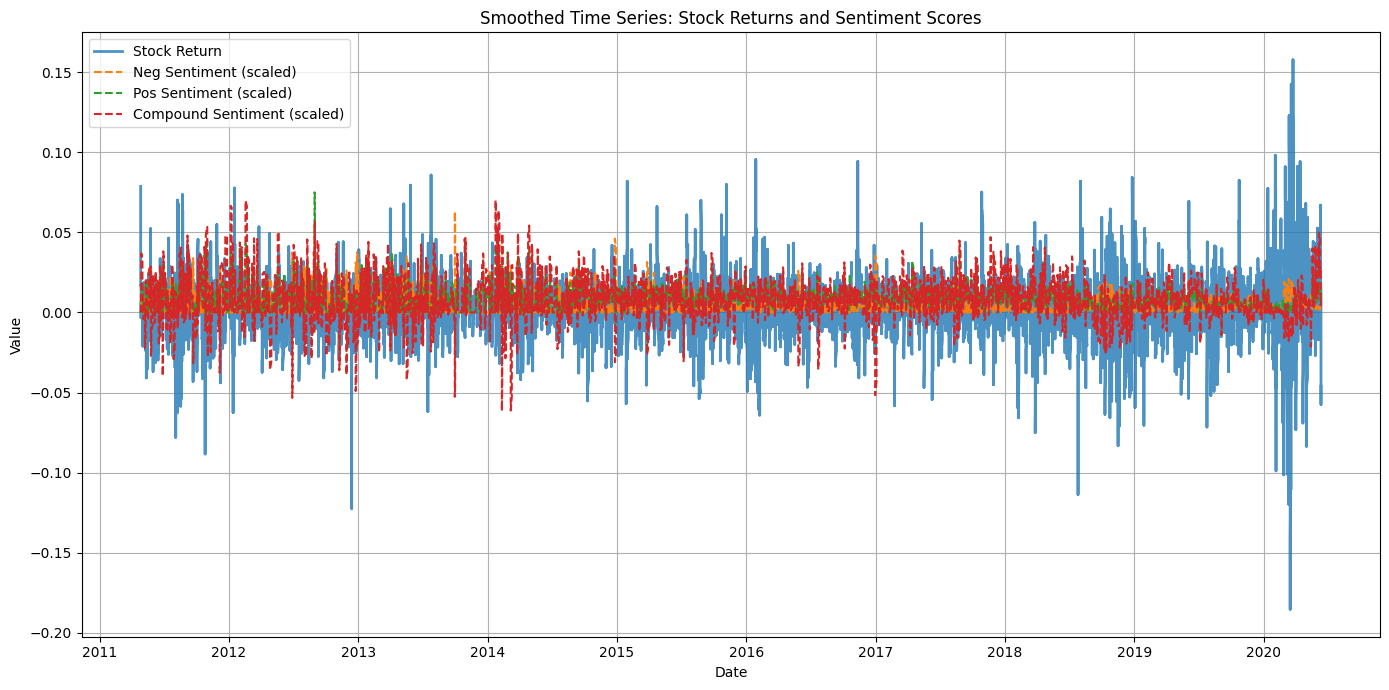

In [159]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'trading_day' is in datetime format and sort the data
merged_new_df['trading_day'] = pd.to_datetime(merged_new_df['trading_day'])
merged_new_df = merged_new_df.sort_values(by='trading_day')

# Optionally apply rolling average for smoothing (e.g., 7-day)
merged_new_df['stock_return_smooth'] = merged_new_df['stock_return'].rolling(window=7, min_periods=1).mean()
merged_new_df['neg_smooth'] = merged_new_df['neg'].rolling(window=7, min_periods=1).mean()
merged_new_df['pos_smooth'] = merged_new_df['pos'].rolling(window=7, min_periods=1).mean()
merged_new_df['compound_smooth'] = merged_new_df['compound'].rolling(window=7, min_periods=1).mean()

# Plotting
plt.figure(figsize=(14, 7))

plt.plot(merged_new_df['trading_day'], merged_new_df['stock_return_smooth'], label='Stock Return', alpha=0.8, linewidth=2)
plt.plot(merged_new_df['trading_day'], merged_new_df['neg_smooth'] * 0.1, label='Neg Sentiment (scaled)', linestyle='--')
plt.plot(merged_new_df['trading_day'], merged_new_df['pos_smooth'] * 0.1, label='Pos Sentiment (scaled)', linestyle='--')
plt.plot(merged_new_df['trading_day'], merged_new_df['compound_smooth'] * 0.1, label='Compound Sentiment (scaled)', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Smoothed Time Series: Stock Returns and Sentiment Scores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Scatter Plots: Sentiment vs. Stock Returns
These scatter plots illustrate the direct relationship between each sentiment score and the corresponding daily stock return.

Each plot represents:

X-axis: Sentiment score (negative, neutral, positive, or compound)

Y-axis: Stock return

Purpose: To visually inspect whether higher/lower sentiment values are associated with increased or decreased returns.

Useful for identifying correlation patterns or outliers.

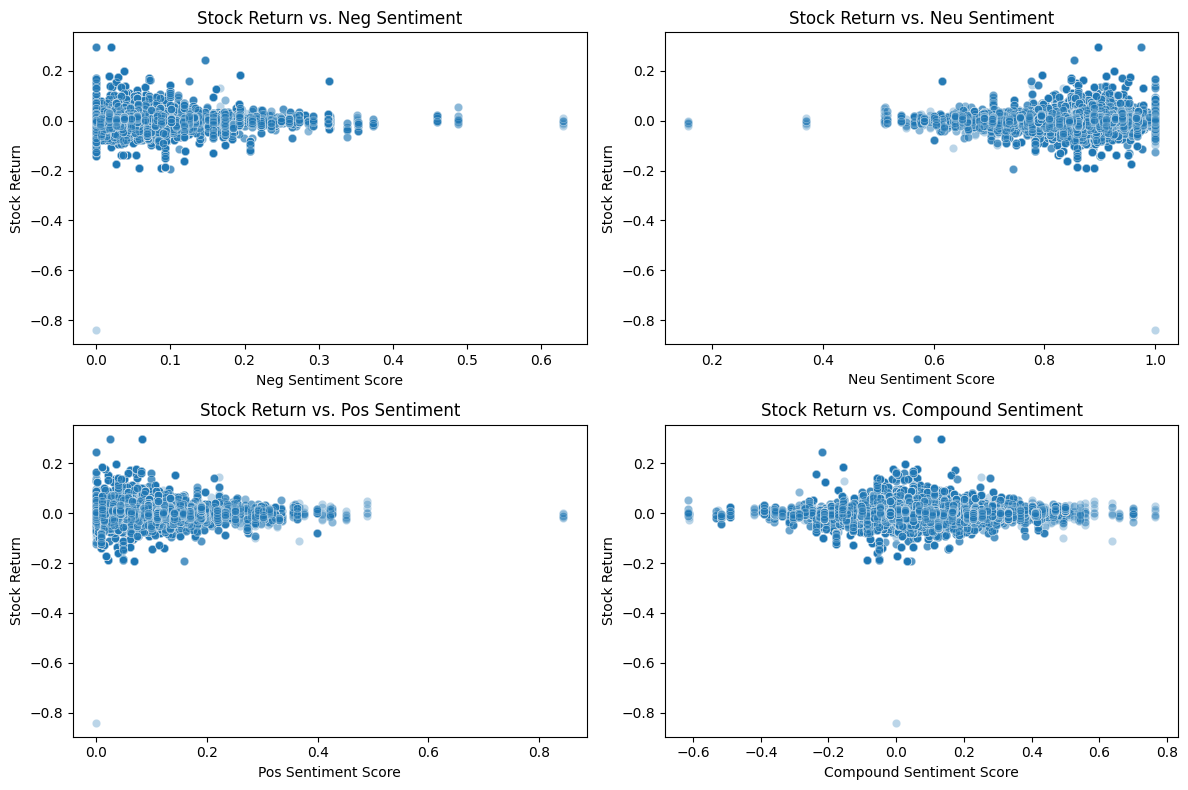

In [157]:
import seaborn as sns

plt.figure(figsize=(12,8))

for i, sentiment_col in enumerate(['neg', 'neu', 'pos', 'compound'], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=merged_new_df[sentiment_col], y=merged_new_df['stock_return'], alpha=0.3)
    plt.title(f'Stock Return vs. {sentiment_col.capitalize()} Sentiment')
    plt.xlabel(f'{sentiment_col.capitalize()} Sentiment Score')
    plt.ylabel('Stock Return')

plt.tight_layout()
plt.show()


## Heatmap of Correlation Matrix
A heatmap displaying Pearson correlation coefficients among:

neg, neu, pos, compound sentiment scores

stock_return

Purpose: To quickly assess the strength and direction of linear relationships between sentiment and stock returns.

Color scale indicates:

Strong positive correlation (near +1)

Strong negative correlation (near -1)

Weak or no correlation (near 0)

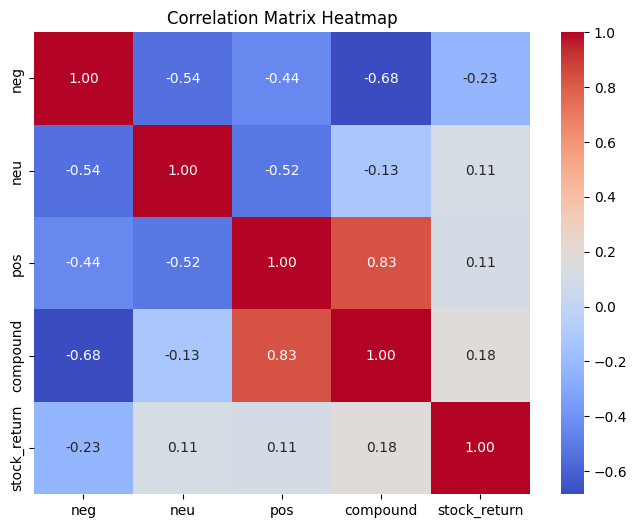

In [158]:
import seaborn as sns

corr = merged_new_df[['neg', 'neu', 'pos', 'compound', 'stock_return']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

